In [1]:
import pickle 
import sys

import pandas as pd
import numpy as np

import gc

from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline

import random
import nltk

from PIL import Image

sys.path.append('/DS/Customer/RSRC')

from nltk.tokenize import sent_tokenize, RegexpTokenizer
from nltk.corpus import stopwords


from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import seaborn as sns
import matplotlib.pyplot as plt

from wordcloud import WordCloud

random.seed(42)

pd.set_option('display.max_rows', 500)
nltk.download('stopwords')

turkish_stop_words = set(stopwords.words('turkish'))

turkey_mask = np.array(Image.open('turkey_map.jpg'))

[nltk_data] Downloading package stopwords to /home/toprak/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
def extract_unigrams(text: list) -> pd.DataFrame:
    vectorizer = CountVectorizer(ngram_range =(1, 1), max_df=1.0, min_df=1)
    X1 = vectorizer.fit_transform(text) 
    features = vectorizer.get_feature_names()

    sums = X1.sum(axis = 0)
    data1 = []
    for col, term in enumerate(features):
        data1.append( (term, sums[0, col] ))
    ranking = pd.DataFrame(data1, columns = ['ngram', 'rank'])
    return ranking.sort_values('rank', ascending = False)

In [3]:
def extract_bigrams(text: list) -> pd.DataFrame:
    vectorizer = CountVectorizer(ngram_range =(2, 2), max_df=0.5, min_df=2)
    X1 = vectorizer.fit_transform(text) 
    features = vectorizer.get_feature_names()

    sums = X1.sum(axis = 0)
    data1 = []
    for col, term in enumerate(features):
        data1.append( (term, sums[0, col] ))
    ranking = pd.DataFrame(data1, columns = ['ngram', 'rank'])
    return ranking.sort_values('rank', ascending = False)

In [4]:
def extract_trigrams(text: list) -> pd.DataFrame:
    vectorizer = CountVectorizer(ngram_range =(3, 3), max_df=0.5, min_df=2)
    X1 = vectorizer.fit_transform(text) 
    features = vectorizer.get_feature_names()

    sums = X1.sum(axis = 0)
    data1 = []
    for col, term in enumerate(features):
        data1.append( (term, sums[0, col] ))
    ranking = pd.DataFrame(data1, columns = ['ngram', 'rank'])
    return ranking.sort_values('rank', ascending = False)

In [5]:
def extract_fourgrams(text: list) -> pd.DataFrame:
    vectorizer = CountVectorizer(ngram_range =(4, 4), max_df=0.5, min_df=2)
    X1 = vectorizer.fit_transform(text) 
    features = vectorizer.get_feature_names()

    sums = X1.sum(axis = 0)
    data1 = []
    for col, term in enumerate(features):
        data1.append( (term, sums[0, col] ))
    ranking = pd.DataFrame(data1, columns = ['ngram', 'rank'])
    return ranking.sort_values('rank', ascending = False)

In [6]:
kk_pairs = [
    {'start':1597.04, 'end':2753.92},
    {'start':1258.7, 'end':2830.5},
    {'start':1660.0, 'end':2963.0},
    {'start':3640.22, 'end':5269.59},
    {'start':2647.52, 'end':3894.44},
    {'start':1743.04, 'end':3123.18},
    {'start':2807.0, 'end':4416},
    {'start':1791.8, 'end':3486.56}  
           ]

In [7]:
with open('KK_and_RTE_language_analysis_final.pkl', 'rb') as f:
    analysis = pickle.load(f)

In [8]:
cleaned_kk_scripts = []
time_index = 0
for kk_script in analysis['KK']:
    if len(kk_pairs[time_index]) > 0:
        scripts = [script['text'] for script in kk_script['raw_scripts']
                   if (script['start'] >= kk_pairs[time_index]['start']) & (script['end'] <= kk_pairs[time_index]['end'])]
        cleaned_kk_scripts.append(scripts)
    else:
        cleaned_kk_scripts.append([])
    time_index += 1

In [9]:
cleaned_rte_scripts = []
for rte_script in analysis['RTE']:
    scripts = [script['text'] for script in rte_script['raw_scripts']]
    cleaned_rte_scripts.append(sent_tokenize(''.join(scripts)))

In [10]:
cleaned_kk_scripts = [sent_tokenize(''.join(scripts)) for scripts in cleaned_kk_scripts if len(scripts)>0]

In [11]:
cleaned_analysis = {}
cleaned_analysis['KK'] = cleaned_kk_scripts
cleaned_analysis['RTE'] = cleaned_rte_scripts

In [12]:
tokenizer = RegexpTokenizer(r'\w+')

punct_removed_analysis = {}
punct_removed_analysis['KK'] = [[" ".join(tokenizer.tokenize(script)) for script in scripts] for scripts in cleaned_kk_scripts]
punct_removed_analysis['RTE'] = [[" ".join(tokenizer.tokenize(script)) for script in scripts] for scripts in cleaned_rte_scripts]

In [13]:
non_stop_words_punct_removed_analysis = {}
non_stop_words_punct_removed_analysis['KK'] = [[" ".join([word.lower() for word in script.split() if word.lower() not in turkish_stop_words]) 
                                                for script in scripts] 
                                               for scripts in punct_removed_analysis['KK']]
non_stop_words_punct_removed_analysis['RTE'] = [[" ".join([word.lower() for word in script.split() if word.lower() not in turkish_stop_words]) 
                                                for script in scripts] 
                                               for scripts in punct_removed_analysis['RTE']]

In [14]:
tokenizer = RegexpTokenizer(r'\w+')

tokenized_analysis = {}
tokenized_analysis['KK'] = [[tokenizer.tokenize(script) for script in scripts] for scripts in cleaned_kk_scripts]
tokenized_analysis['RTE'] = [[tokenizer.tokenize(script) for script in scripts] for scripts in cleaned_rte_scripts]

In [15]:
all_KK_scripts = []
for scripts in tokenized_analysis['KK']:
    all_KK_scripts.extend(sum(scripts, []))

all_KK_scripts = [word for word in all_KK_scripts if len(word) > 2]

In [16]:
all_RTE_scripts = []
for scripts in tokenized_analysis['RTE']:
    all_RTE_scripts.extend(sum(scripts, []))

all_RTE_scripts = [word for word in all_RTE_scripts if len(word) > 2]

In [17]:
def count_words(scripts:list, searched_word_list:list) -> dict:
    searched_words_counts = {key:0 for key in searched_word_list}
    for searched_word in searched_words_counts.keys():
        count = len([word for word in scripts 
                                                    if searched_word in word.lower()
                                                    .replace("ü", 'u')
                                                    .replace('ö', 'o')
                                                    .replace('ş', 's')
                                                    .replace('ç', 'c')
                                                    .replace('ğ', 'g')]) 
        searched_words_counts[searched_word] = len(scripts)/count if count > 0 else 0
    return searched_words_counts

In [18]:
religious_words = ['allah', 'islam', 'namaz', 'musluman', 'gunah', 'cehennem', 'cennet']

print(count_words(all_KK_scripts, religious_words))
print(count_words(all_RTE_scripts, religious_words))

{'allah': 307.13461538461536, 'islam': 0, 'namaz': 0, 'musluman': 0, 'gunah': 3194.2, 'cehennem': 0, 'cennet': 15971.0}
{'allah': 259.80392156862746, 'islam': 0, 'namaz': 0, 'musluman': 0, 'gunah': 0, 'cehennem': 0, 'cennet': 26500.0}


In [19]:
terrorism_words = ['ocalan', 'teror', 'pkk', 'hizbullah', 'silah', 'bomba', 'savas']

print(count_words(all_KK_scripts, terrorism_words))
print(count_words(all_RTE_scripts, terrorism_words))

{'ocalan': 0, 'teror': 1451.909090909091, 'pkk': 0, 'hizbullah': 0, 'silah': 0, 'bomba': 0, 'savas': 3992.75}
{'ocalan': 13250.0, 'teror': 456.8965517241379, 'pkk': 662.5, 'hizbullah': 0, 'silah': 2944.4444444444443, 'bomba': 13250.0, 'savas': 1892.857142857143}


In [20]:
speaking_words = ['canim', 'kardes', 'sevgili', 'dost', 'yoldas']

print(count_words(all_KK_scripts, speaking_words))
print(count_words(all_RTE_scripts, speaking_words))

{'canim': 0, 'kardes': 224.94366197183098, 'sevgili': 1330.9166666666667, 'dost': 5323.666666666667, 'yoldas': 0}
{'canim': 0, 'kardes': 187.94326241134752, 'sevgili': 2944.4444444444443, 'dost': 2944.4444444444443, 'yoldas': 5300.0}


In [21]:
candidate_names = ['recep', 'tayyip', 'erdogan', 'kemal', 'kilicdaroglu']

print(count_words(all_KK_scripts, candidate_names))
print(count_words(all_RTE_scripts, candidate_names))

{'recep': 0, 'tayyip': 0, 'erdogan': 0, 'kemal': 207.41558441558442, 'kilicdaroglu': 0}
{'recep': 26500.0, 'tayyip': 13250.0, 'erdogan': 4416.666666666667, 'kemal': 197.76119402985074, 'kilicdaroglu': 0}


In [22]:
governmental_words = ['suriye', 'sinir', 'siginma', 'goc', 'guvenlik', 'asker', 'ordu']

print(count_words(all_KK_scripts, governmental_words))
print(count_words(all_RTE_scripts, governmental_words))

{'suriye': 798.55, 'sinir': 15971.0, 'siginma': 0, 'goc': 7985.5, 'guvenlik': 1996.375, 'asker': 1140.7857142857142, 'ordu': 760.5238095238095}
{'suriye': 2650.0, 'sinir': 0, 'siginma': 0, 'goc': 0, 'guvenlik': 13250.0, 'asker': 2038.4615384615386, 'ordu': 427.4193548387097}


In [23]:
job_words = ['doktor', 'ogretmen', 'muhendis', 'ogrenci', 'issiz', 'atama']

print(count_words(all_KK_scripts, job_words))
print(count_words(all_RTE_scripts, job_words))

{'doktor': 0, 'ogretmen': 290.3818181818182, 'muhendis': 1597.1, 'ogrenci': 3992.75, 'issiz': 1064.7333333333333, 'atama': 798.55}
{'doktor': 26500.0, 'ogretmen': 3785.714285714286, 'muhendis': 0, 'ogrenci': 854.8387096774194, 'issiz': 4416.666666666667, 'atama': 13250.0}


In [24]:
politics_words = ['ataturk', 
                  'selahattin', 
                  'bahceli', 
                  'cumhuriyet', 
                  'demokrasi', 
                  'secim', 
                  'sosyal',
                  'ulkucu', 
                  'milliyetci']

print(count_words(all_KK_scripts, politics_words))
print(count_words(all_RTE_scripts, politics_words))

{'ataturk': 1996.375, 'selahattin': 0, 'bahceli': 0, 'cumhuriyet': 887.2777777777778, 'demokrasi': 1140.7857142857142, 'secim': 1140.7857142857142, 'sosyal': 665.4583333333334, 'ulkucu': 0, 'milliyetci': 399.275}
{'ataturk': 1892.857142857143, 'selahattin': 4416.666666666667, 'bahceli': 0, 'cumhuriyet': 854.8387096774194, 'demokrasi': 2409.090909090909, 'secim': 828.125, 'sosyal': 1060.0, 'ulkucu': 0, 'milliyetci': 3785.714285714286}


In [25]:
party_names = ['akp', 'chp', 'cehape', 'hdp', 'mhp']

print(count_words(all_KK_scripts, party_names))
print(count_words(all_RTE_scripts, party_names))

{'akp': 0, 'chp': 15971.0, 'cehape': 0, 'hdp': 0, 'mhp': 0}
{'akp': 8833.333333333334, 'chp': 500.0, 'cehape': 0, 'hdp': 358.1081081081081, 'mhp': 3785.714285714286}


In [26]:
economics_words = ['para', 'dolar', 'euro', 'ekonomi', 'yatirim', 'fabrika', 'kopru', 'pahali', 'gecin', 'fakir']

print(count_words(all_KK_scripts, economics_words))
print(count_words(all_RTE_scripts, economics_words))

{'para': 187.89411764705883, 'dolar': 1330.9166666666667, 'euro': 0, 'ekonomi': 3992.75, 'yatirim': 0, 'fabrika': 1774.5555555555557, 'kopru': 7985.5, 'pahali': 0, 'gecin': 3992.75, 'fakir': 1228.5384615384614}
{'para': 2409.090909090909, 'dolar': 828.125, 'euro': 0, 'ekonomi': 913.7931034482758, 'yatirim': 0, 'fabrika': 3785.714285714286, 'kopru': 679.4871794871794, 'pahali': 0, 'gecin': 0, 'fakir': 0}


In [27]:
election_words = ['baybay kemal', 'on dort', ' bay kemal', 'cumhurbaskan']

print(count_words(sum(punct_removed_analysis['RTE'], []), election_words))
print(count_words(sum(punct_removed_analysis['KK'], []), election_words))

{'baybay kemal': 54.784615384615385, 'on dort': 34.57281553398058, ' bay kemal': 136.96153846153845, 'cumhurbaskan': 114.87096774193549}
{'baybay kemal': 0, 'on dort': 535.3333333333334, ' bay kemal': 118.96296296296296, 'cumhurbaskan': 128.48}


In [28]:
personal_words = ['ben', 'sen', 'onlar', 'yalniz', 'bunlar']

print(count_words(all_KK_scripts, personal_words))
print(count_words(all_RTE_scripts, personal_words))

{'ben': 91.26285714285714, 'sen': 249.546875, 'onlar': 101.08227848101266, 'yalniz': 0, 'bunlar': 290.3818181818182}
{'ben': 262.3762376237624, 'sen': 196.2962962962963, 'onlar': 427.4193548387097, 'yalniz': 0, 'bunlar': 164.59627329192546}


In [29]:
pd.concat([extract_fourgrams(sum(non_stop_words_punct_removed_analysis['KK'], []))[:100].reset_index(drop=True), 
           extract_trigrams(sum(non_stop_words_punct_removed_analysis['KK'], []))[:100].reset_index(drop=True),
           extract_bigrams(sum(non_stop_words_punct_removed_analysis['KK'], []))[:100].reset_index(drop=True),
           extract_unigrams(sum(non_stop_words_punct_removed_analysis['KK'], []))[:100].reset_index(drop=True)],axis=1)

,ngram,rank,ngram,rank,ngram,rank,ngram,rank
0,yirmi yedi buçuk yıl,10,yirmi yedi buçuk,13,bay kemal,56,bir,471
1,geç iki yıl içinde,8,parayı nereden bulacaksın,13,endişe etmeyin,52,var,230
2,köy okullarını yeniden açacağız,7,bir türkiye yi,12,kul hakkı,38,türkiye,126
3,gazi mustafa kemal atatürk,7,size sözüm var,11,sözüm var,31,bütün,106
4,allah nasip eder sizlerin,6,asgari ücret kadar,11,türkiye nin,29,söz,101
5,yüz on sekiz milyar,6,yedi buçuk yıl,10,güzel bir,29,ben,93
6,beş milyon üç yüz,6,bay kemal in,10,türkiye yi,25,güzel,80
7,sağ elin verdiğini sol,6,gayet iyi biliyorum,10,bir türkiye,25,kemal,76
8,bundan emin olmanızı isterim,6,gazi mustafa kemal,10,huzur içinde,25,yok,73
9,benim size sözüm var,6,on beş bin,10,yüz bin,18,biliyorum,72


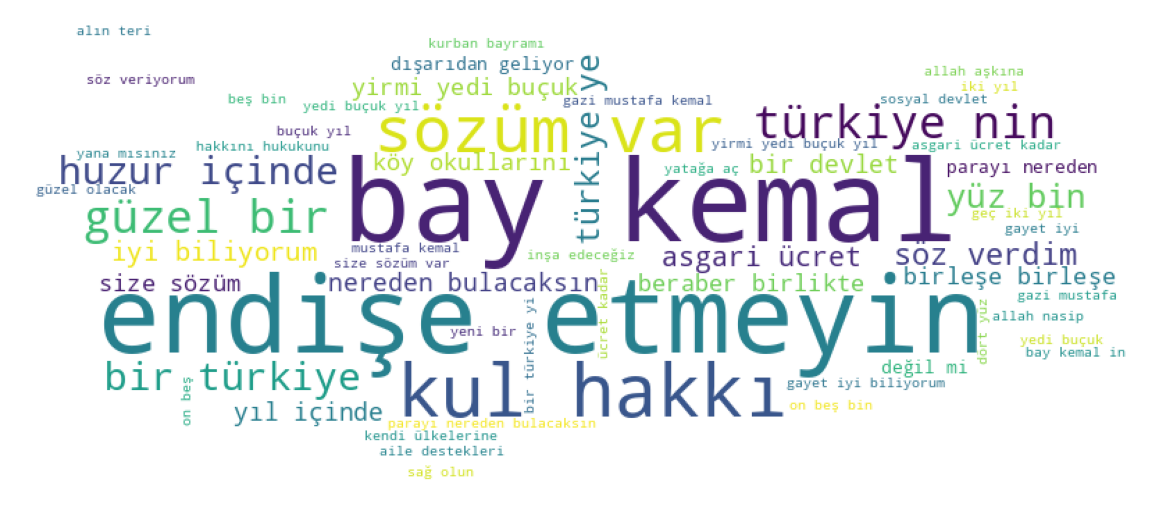

In [30]:
df = pd.concat([extract_fourgrams(sum(non_stop_words_punct_removed_analysis['KK'], []))[:100].reset_index(drop=True), 
           extract_trigrams(sum(non_stop_words_punct_removed_analysis['KK'], []))[:100].reset_index(drop=True),
           extract_bigrams(sum(non_stop_words_punct_removed_analysis['KK'], []))[:100].reset_index(drop=True)],axis=0).sort_values('rank', ascending=False)

df = df[~df['ngram'].isin(['yirmi yedi', 
                           'bin lira', 
                           'türkiye yi', 
                           'kemal in'])]

wordcloud = WordCloud(width=800, 
                          height=800,
                          background_color='white',
                          min_font_size=10,
                          random_state=1,
                          mask=turkey_mask
                         ).generate_from_frequencies(dict(zip(list(df['ngram']), list(df['rank']))))

# Display the word cloud
plt.figure(figsize=(16,16), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [31]:
pd.concat([extract_fourgrams(sum(non_stop_words_punct_removed_analysis['RTE'], []))[:100].reset_index(drop=True), 
           extract_trigrams(sum(non_stop_words_punct_removed_analysis['RTE'], []))[:100].reset_index(drop=True),
           extract_bigrams(sum(non_stop_words_punct_removed_analysis['RTE'], []))[:100].reset_index(drop=True),
           extract_unigrams(sum(non_stop_words_punct_removed_analysis['RTE'], []))[:100].reset_index(drop=True)],axis=1)

,ngram,rank,ngram,rank,ngram,rank,ngram,rank
0,on dört mayıs ta,65,on dört mayıs,97,on dört,103,bir,720
1,son yirmi bir yılda,14,dört mayıs ta,66,dört mayıs,98,on,201
2,yola devam diyor muyuz,11,yirmi yılda yapılamaz,49,bile asla,96,yüz,167
3,doğru adımlarla yola devam,10,bay bay kemal,23,mayıs ta,74,dört,152
4,dört mayıs ta türkiye,10,yirmi bir yılda,22,baybay kemal,65,yirmi,147
5,bakırköy belediye başkanı nın,9,son yirmi bir,18,yirmi yılda,50,bin,142
6,yaşanan bir dram maalesef,8,bin dokuz yüz,14,yılda yapılamaz,49,türkiye,133
7,hastanemizde yaşanan bir dram,8,bin beş yüz,14,yirmi bir,46,kemal,132
8,resim heykel müzesi ni,8,baybay kemal in,13,böyle bir,33,var,127
9,adımlarla yola devam diyor,8,devam diyor muyuz,11,değil mi,28,şimdi,124


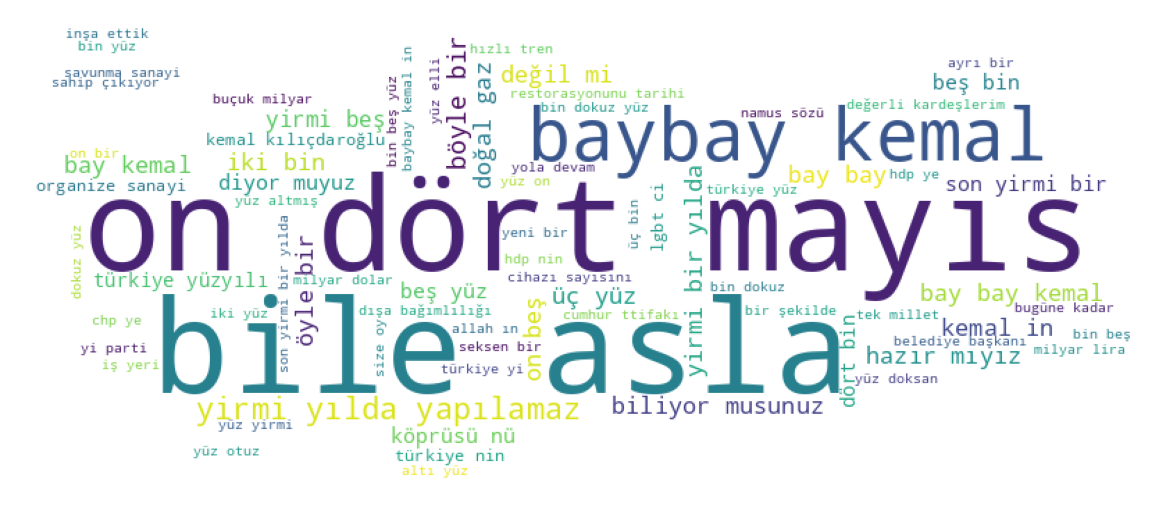

In [32]:
df = pd.concat([extract_fourgrams(sum(non_stop_words_punct_removed_analysis['RTE'], []))[:100].reset_index(drop=True), 
           extract_trigrams(sum(non_stop_words_punct_removed_analysis['RTE'], []))[:100].reset_index(drop=True),
           extract_bigrams(sum(non_stop_words_punct_removed_analysis['RTE'], []))[:100].reset_index(drop=True)],axis=0).sort_values('rank', ascending=False)

df = df[~df['ngram'].isin(['on dört', 
                           'dört mayıs', 
                           'on dört mayıs ta', 
                           'dört mayıs ta', 
                           'mayıs ta', 
                           'yirmi yılda', 
                           'yılda yapılamaz', 
                           'mayis ta', 
                           'yirmi bir', 
                           'son yirmi', 
                           'bir yılda'])]
wordcloud = WordCloud(width=800, 
                          height=800,
                          background_color='white',
                          min_font_size=10,
                          random_state=1,
                          mask=turkey_mask
                         ).generate_from_frequencies(dict(zip(list(df['ngram']), list(df['rank']))))

# Display the word cloud
plt.figure(figsize=(16,16), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [33]:
# https://huggingface.co/zafercavdar/distilbert-base-turkish-cased-emotion

distilbert_classifier = pipeline("text-classification",
                                 model='zafercavdar/distilbert-base-turkish-cased-emotion',
                                 return_all_scores=True)

/home/toprak/.local/lib/python3.9/site-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [34]:
# https://huggingface.co/savasy/bert-base-turkish-sentiment-cased

bert_model = AutoModelForSequenceClassification.from_pretrained("savasy/bert-base-turkish-sentiment-cased")
bert_tokenizer = AutoTokenizer.from_pretrained("savasy/bert-base-turkish-sentiment-cased")
bert_predictor = pipeline("sentiment-analysis", tokenizer=bert_tokenizer, model=bert_model)

In [35]:
cleaned_candidate_scripts = {'KK':[], 'RTE':[]}
for candidate in cleaned_analysis.keys():
    for script_records in cleaned_analysis[candidate]:
        cleaned_scripts = [records for records in script_records if len(records.split()) > 1 and len(records.split()) < 256]
        cleaned_candidate_scripts[candidate].append(cleaned_scripts)
gc.collect()    

41

In [36]:
candidate_records = []
for candidate in cleaned_candidate_scripts.keys():
    for script_records in cleaned_candidate_scripts[candidate]:
        records = pd.DataFrame({'text':script_records})
        records['candidate'] = candidate
        records['source'] = cleaned_candidate_scripts[candidate].index(script_records)
        candidate_records.append(records)
        
candidate_records = pd.concat(candidate_records)
        
gc.collect()

0

In [37]:
def calculate_negative_positive_score(text:str) -> tuple:
    result = bert_predictor(text.lower())
    return result[0]['label'], result[0]['score'] 

In [38]:
def calculate_emotion_scores(text: str) -> tuple:
    prediction = distilbert_classifier(text.lower())
    return prediction[0][0]['score'], prediction[0][1]['score'], prediction[0][2]['score'], prediction[0][3]['score'], prediction[0][4]['score'], prediction[0][5]['score']

In [39]:
%%time

candidate_records['sentiment_label'], \
candidate_records['sentiment_score'] = zip(*candidate_records.apply(lambda x: calculate_negative_positive_score(x['text']), axis=1))

gc.collect()

CPU times: user 17min 17s, sys: 1.67 s, total: 17min 19s
Wall time: 4min 22s


0

In [40]:
%%time

candidate_records['sadness_score'], \
candidate_records['joy_score'], \
candidate_records['love_score'], \
candidate_records['anger_score'], \
candidate_records['fear_score'], \
candidate_records['surprise_score'] = zip(*candidate_records.apply(lambda x: calculate_emotion_scores(x['text']), axis=1))

gc.collect()

CPU times: user 8min 50s, sys: 604 ms, total: 8min 51s
Wall time: 2min 13s


0

In [41]:
threshold = candidate_records['sentiment_score'].mean() - candidate_records['sentiment_score'].std()
print(threshold)

0.7127932445824988


In [42]:
sentiment_records = candidate_records[candidate_records['sentiment_score'] > threshold][['candidate', 'source', 'sentiment_label', 'text', 'sadness_score',  'joy_score',  'love_score',  'anger_score',  'fear_score',  'surprise_score']]

In [43]:
sentiment_records_list = []
for candidate in sentiment_records['candidate'].unique():
    for source in sentiment_records[sentiment_records['candidate']==candidate]['source'].unique():
        sentiment_percentage = sentiment_records[(sentiment_records['candidate']==candidate) & (sentiment_records['source']==source)].groupby(['candidate', 'source', 'sentiment_label']).agg(label_count=('sentiment_label', 'count'))
        sentiment_rates = (sentiment_percentage / sentiment_percentage.groupby(level=0).sum()).reset_index()
        sentiment_records_list.append(sentiment_rates)

both_sentiment_records = pd.concat(sentiment_records_list)

In [44]:
sentiment_records[(sentiment_records['candidate']=='KK')].value_counts('sentiment_label', normalize=True)

sentiment_label
negative    0.534633
positive    0.465367
dtype: float64

In [45]:
sentiment_records[(sentiment_records['candidate']=='RTE')].value_counts('sentiment_label', normalize=True)

sentiment_label
negative    0.592219
positive    0.407781
dtype: float64

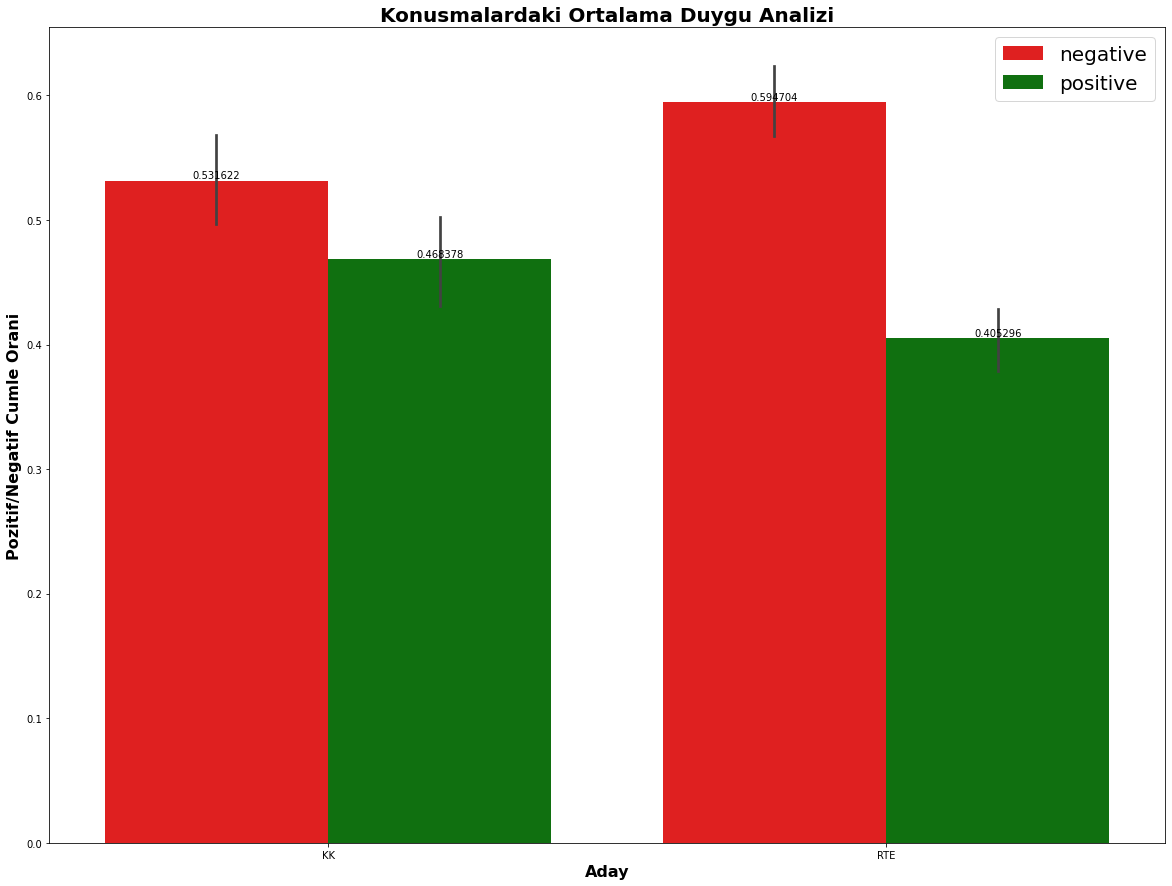

In [46]:
plt.figure(figsize=(20, 15)) 
ax = sns.barplot(x="candidate",
                 y="label_count",
                 hue="sentiment_label",
                 palette=['red', 'green'],
                 data=both_sentiment_records)
for i in ax.containers:
    ax.bar_label(i,)
plt.title('Konusmalardaki Ortalama Duygu Analizi', 
          fontsize = 20, 
          loc='center', 
          fontdict=dict(weight='bold'))
plt.xlabel('Aday', fontsize = 16, fontdict=dict(weight='bold'))
plt.ylabel('Pozitif/Negatif Cumle Orani', fontsize = 16, fontdict=dict(weight='bold'))
plt.legend(loc="upper right", frameon=True, fontsize=20)
plt.show()

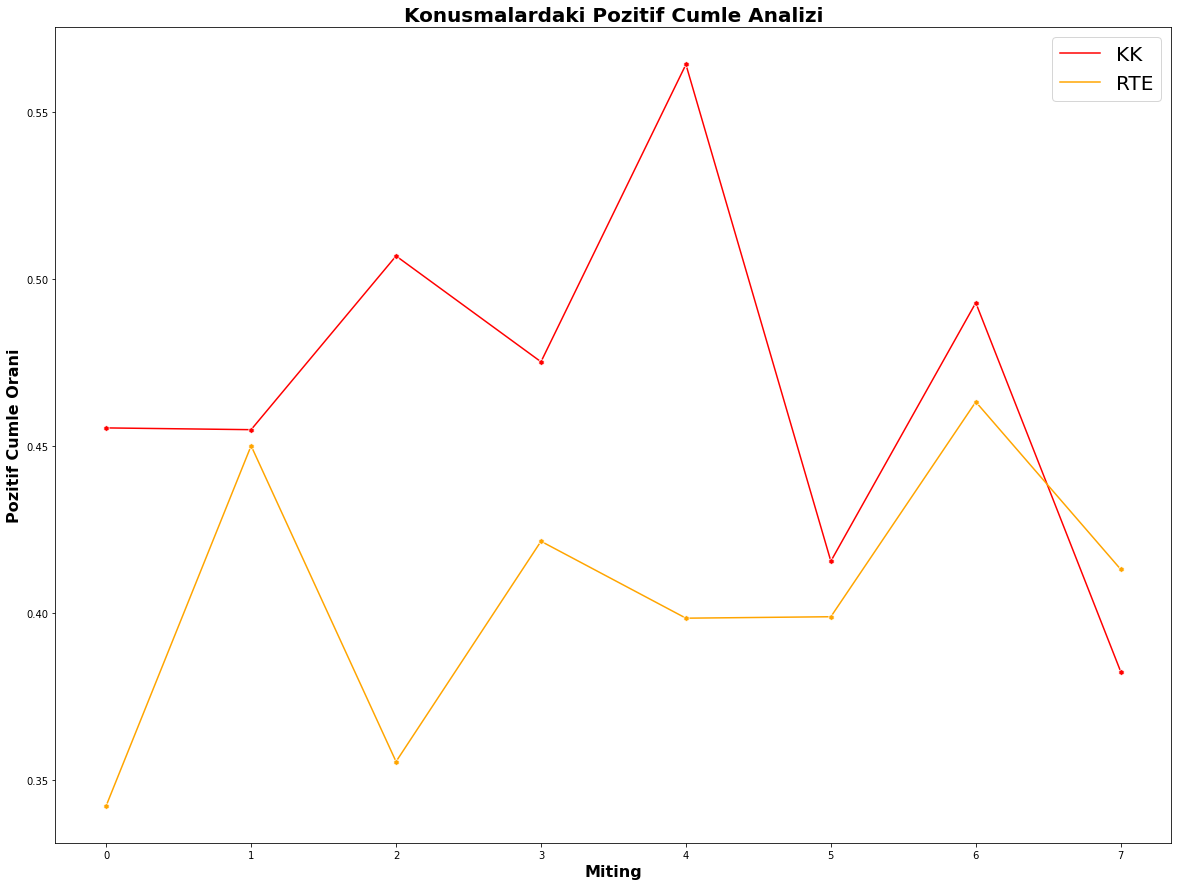

In [47]:
plt.figure(figsize=(20, 15)) 
sns.lineplot(x='source', 
             y='label_count',
             marker= 'h',
             palette=['red', 'orange'],
             hue='candidate',
             data=both_sentiment_records[both_sentiment_records['sentiment_label']=='positive'].reset_index(drop=True))
plt.title('Konusmalardaki Pozitif Cumle Analizi', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
plt.xlabel('Miting', fontsize = 16, fontdict=dict(weight='bold'))
plt.ylabel('Pozitif Cumle Orani', fontsize = 16, fontdict=dict(weight='bold'))
plt.legend(loc="upper right", frameon=True, fontsize=20)
plt.show()

In [48]:
both_sentiment_records[both_sentiment_records['candidate']=='KK']

,candidate,source,sentiment_label,label_count
0,KK,0,negative,0.544643
1,KK,0,positive,0.455357
0,KK,1,negative,0.545171
1,KK,1,positive,0.454829
0,KK,2,negative,0.493151
1,KK,2,positive,0.506849
0,KK,3,negative,0.524845
1,KK,3,positive,0.475155
0,KK,4,negative,0.435798
1,KK,4,positive,0.564202


In [49]:
both_sentiment_records[both_sentiment_records['candidate']=='RTE']

,candidate,source,sentiment_label,label_count
0,RTE,0,negative,0.657795
1,RTE,0,positive,0.342205
0,RTE,1,negative,0.550000
1,RTE,1,positive,0.450000
0,RTE,2,negative,0.644578
1,RTE,2,positive,0.355422
0,RTE,3,negative,0.578595
1,RTE,3,positive,0.421405
0,RTE,4,negative,0.601626
1,RTE,4,positive,0.398374


In [50]:
sentiment_records.value_counts('candidate')

candidate
RTE    2776
KK     2411
dtype: int64

In [51]:
candidate_emotions = []
for candidate in candidate_records['candidate'].unique():
    emotions = candidate_records[(candidate_records['candidate']==candidate)].groupby(['candidate']).agg(sadness_score=('sadness_score', 'mean'),
                                                                                                                                                        joy_score=('joy_score', 'mean'),
                                                                                                                                                        love_score=('love_score', 'mean'),
                                                                                                                                                        anger_score=('anger_score', 'mean'),
                                                                                                                                                        fear_score=('fear_score', 'mean'),
                                                                                                                                                        surprise_score=('surprise_score', 'mean'))
    candidate_emotions.append(emotions)
candidate_emotions = pd.concat(candidate_emotions).reset_index()

In [52]:
print(candidate_emotions.rename(columns = {'sadness_score':'uzuntu',
                                          'joy_score': 'nese',
                                          'love_score': 'sevgi',
                                          'anger_score': 'ofke',
                                          'fear_score': 'korku',
                                          'surprise_score': 'surpriz'}).to_string())

  candidate    uzuntu      nese     sevgi      ofke     korku   surpriz
0        KK  0.198018  0.508298  0.046653  0.145547  0.088146  0.013337
1       RTE  0.218015  0.420179  0.060066  0.188730  0.097447  0.015564


In [53]:
emotion_records_list = []

for candidate in candidate_records['candidate'].unique():
    for source in candidate_records[candidate_records['candidate']==candidate]['source'].unique():
        emotions = candidate_records[(candidate_records['candidate']==candidate) & (candidate_records['source']==source)].groupby(['candidate', 'source']).agg(uzuntu_puani=('sadness_score', 'mean'),
                                                                                                                                                            nese_puani=('joy_score', 'mean'),
                                                                                                                                                            sevgi_puani=('love_score', 'mean'),
                                                                                                                                                            ofke_puani=('anger_score', 'mean'),
                                                                                                                                                            korku_puani=('fear_score', 'mean'),
                                                                                                                                                            surpriz_puani=('surprise_score', 'mean'))
        emotion_records_list.append(emotions)
    

In [54]:
both_emotion_records = pd.concat(emotion_records_list).reset_index()

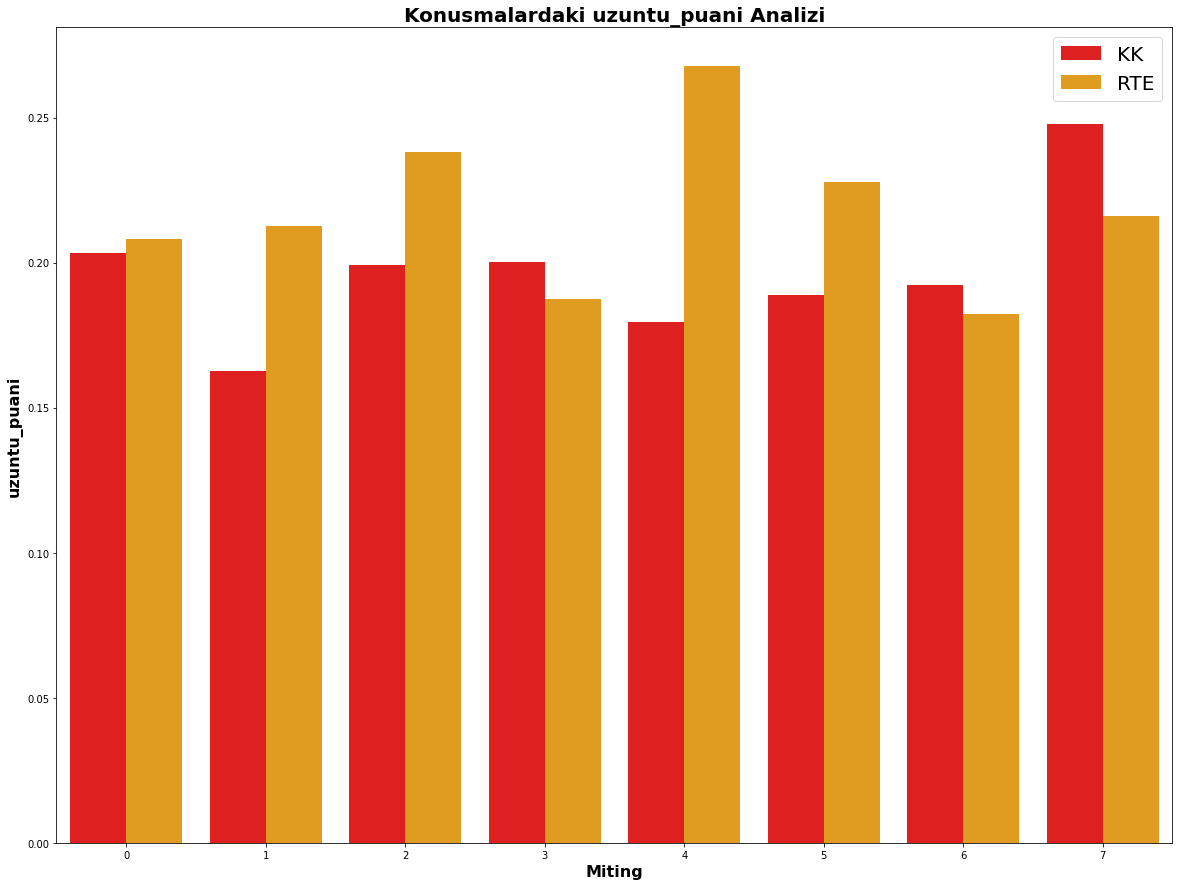

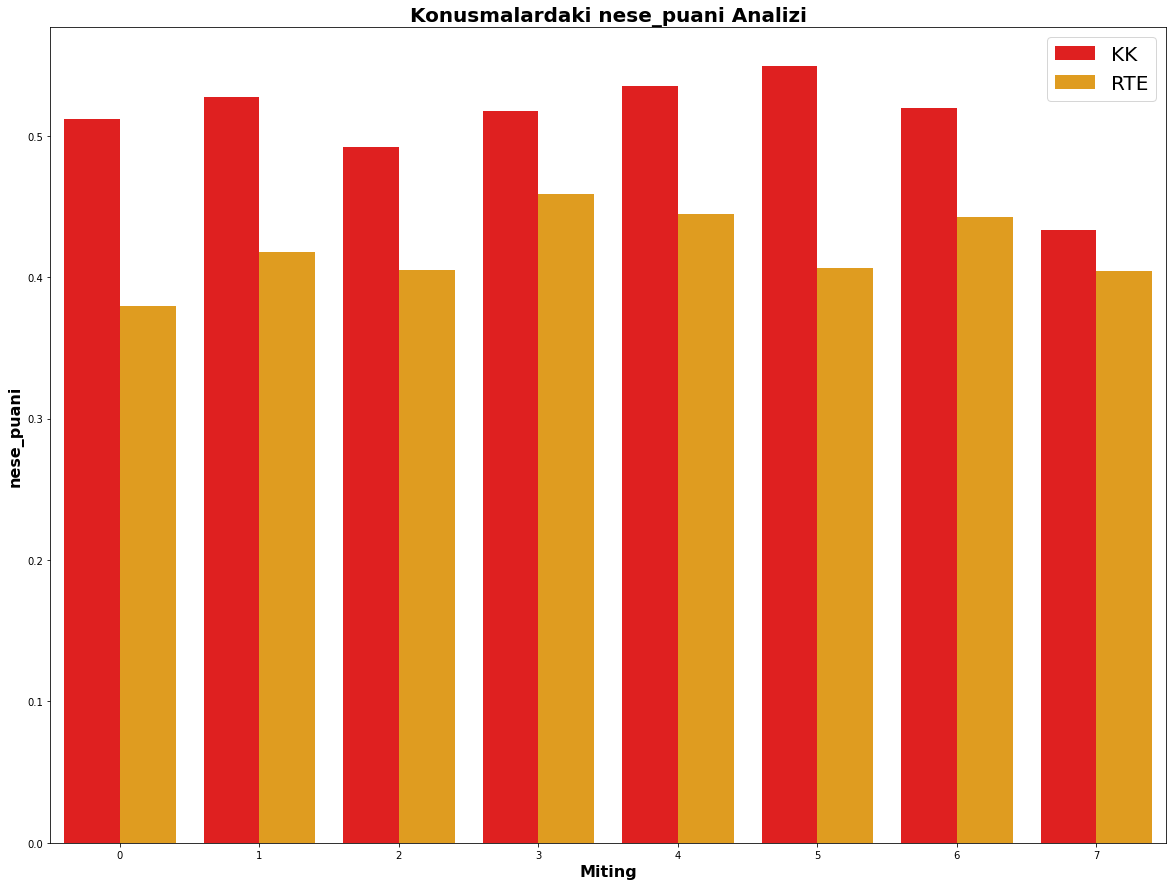

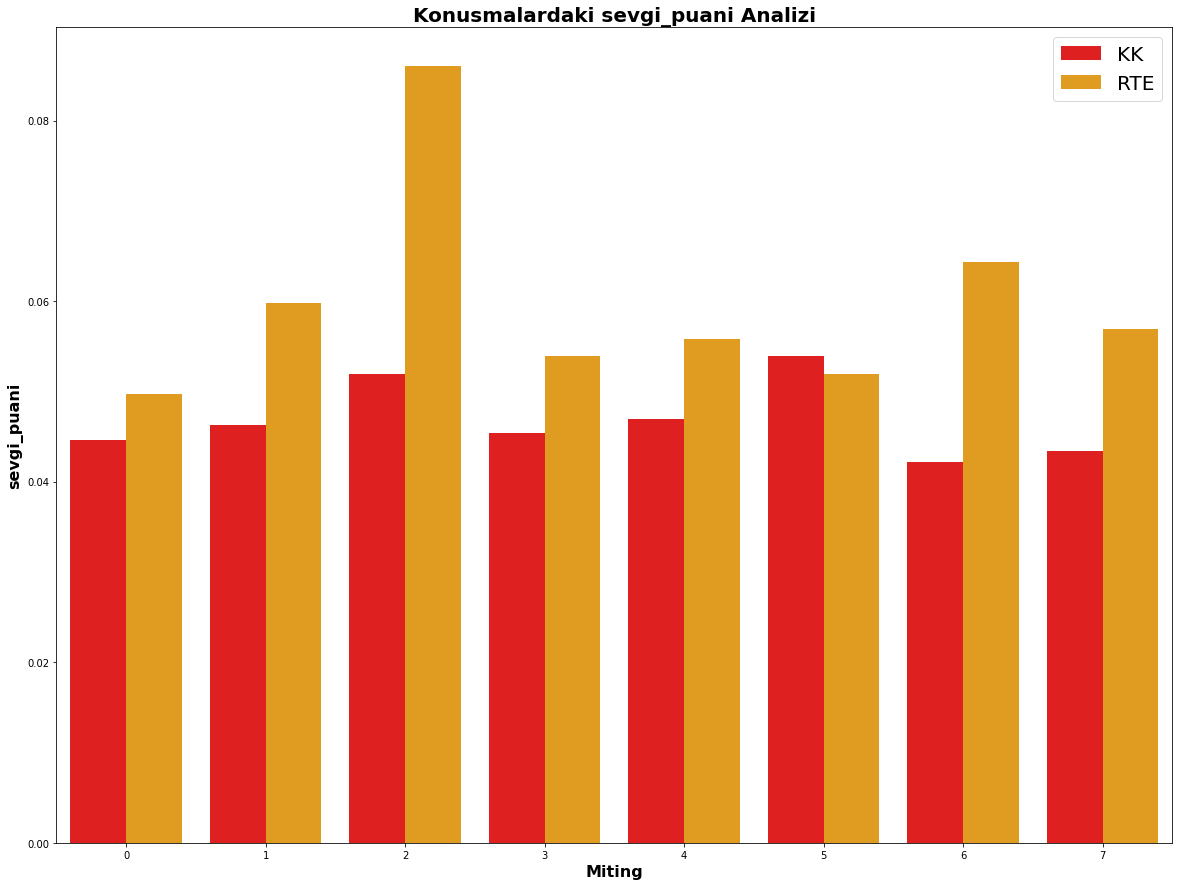

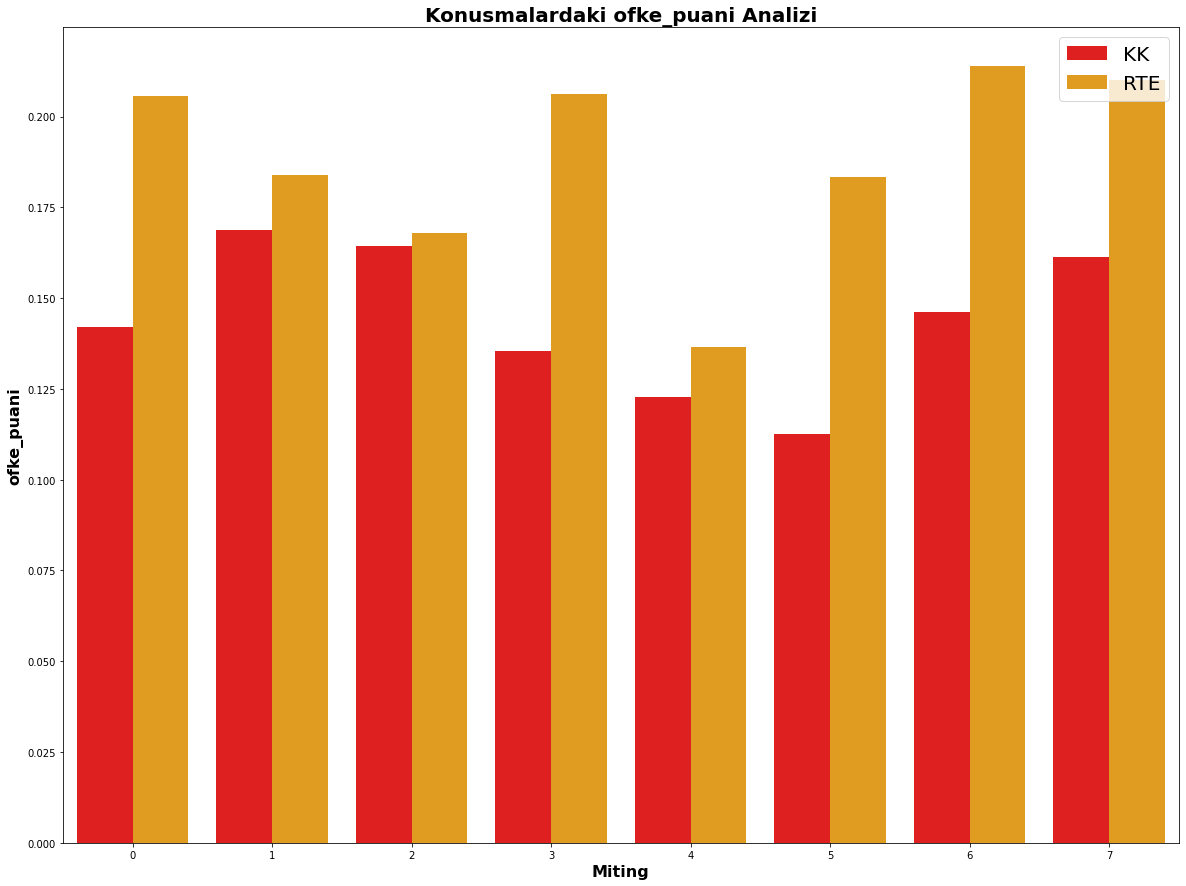

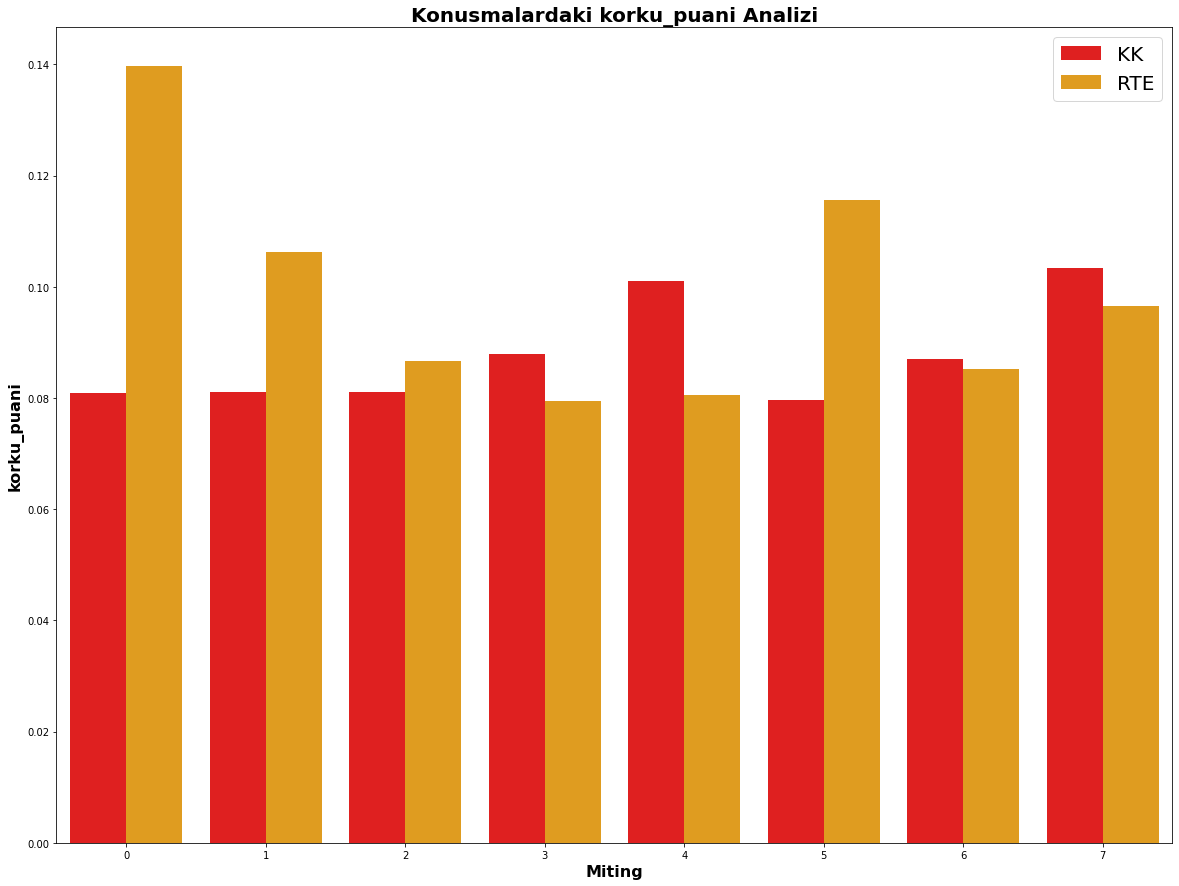

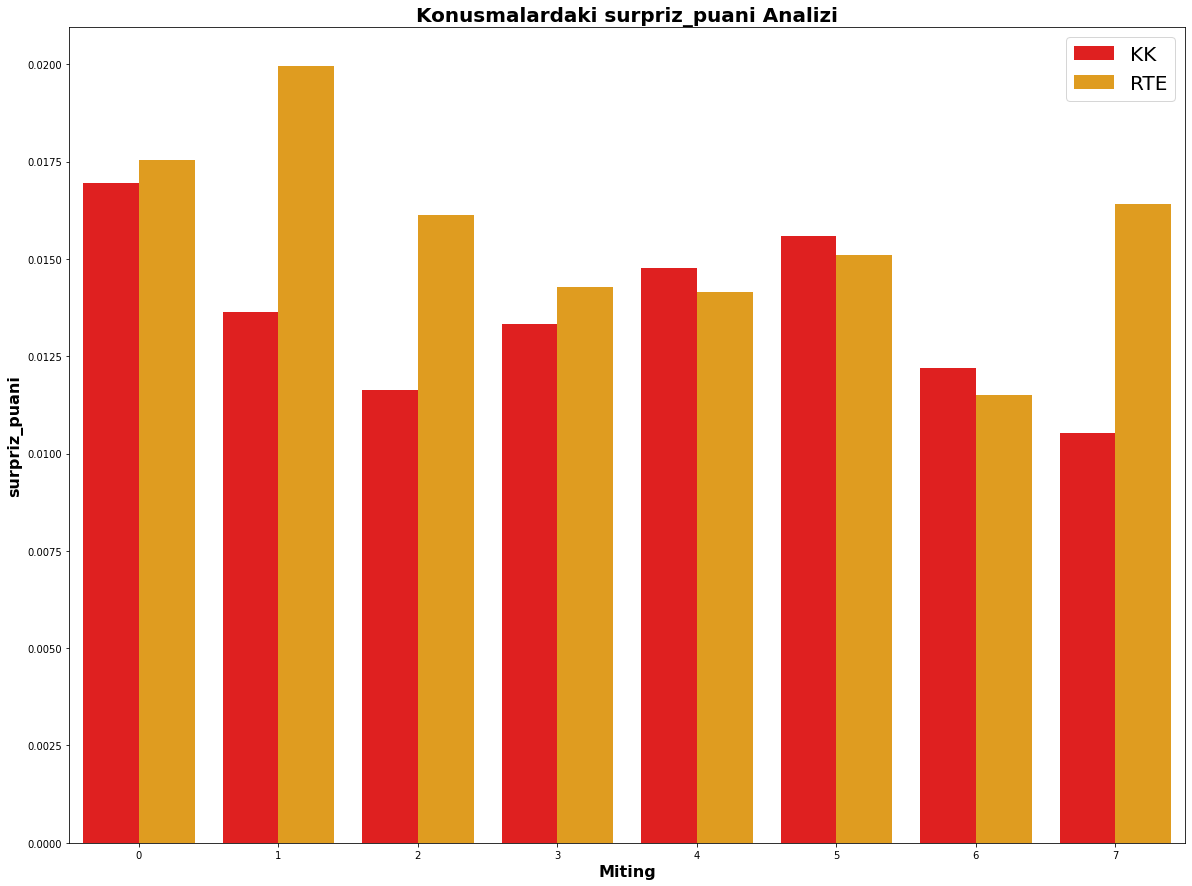

In [55]:
emotions = ['uzuntu_puani', 'nese_puani', 'sevgi_puani', 'ofke_puani', 'korku_puani', 'surpriz_puani']
for emotion in emotions:
    plt.figure(figsize=(20, 15)) 
    sns.barplot(x='source', 
                 y=emotion,
                 palette=['red', 'orange'],
                 hue='candidate',
                 data=both_emotion_records)
    plt.title(f'Konusmalardaki {emotion} Analizi', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
    plt.xlabel('Miting', fontsize = 16, fontdict=dict(weight='bold'))
    plt.ylabel(f'{emotion}', fontsize = 16, fontdict=dict(weight='bold'))
    plt.legend(loc="upper right", frameon=True, fontsize=20)
    plt.show()

In [56]:
candidate_records['word_count'] = candidate_records['text'].str.split().apply(len)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


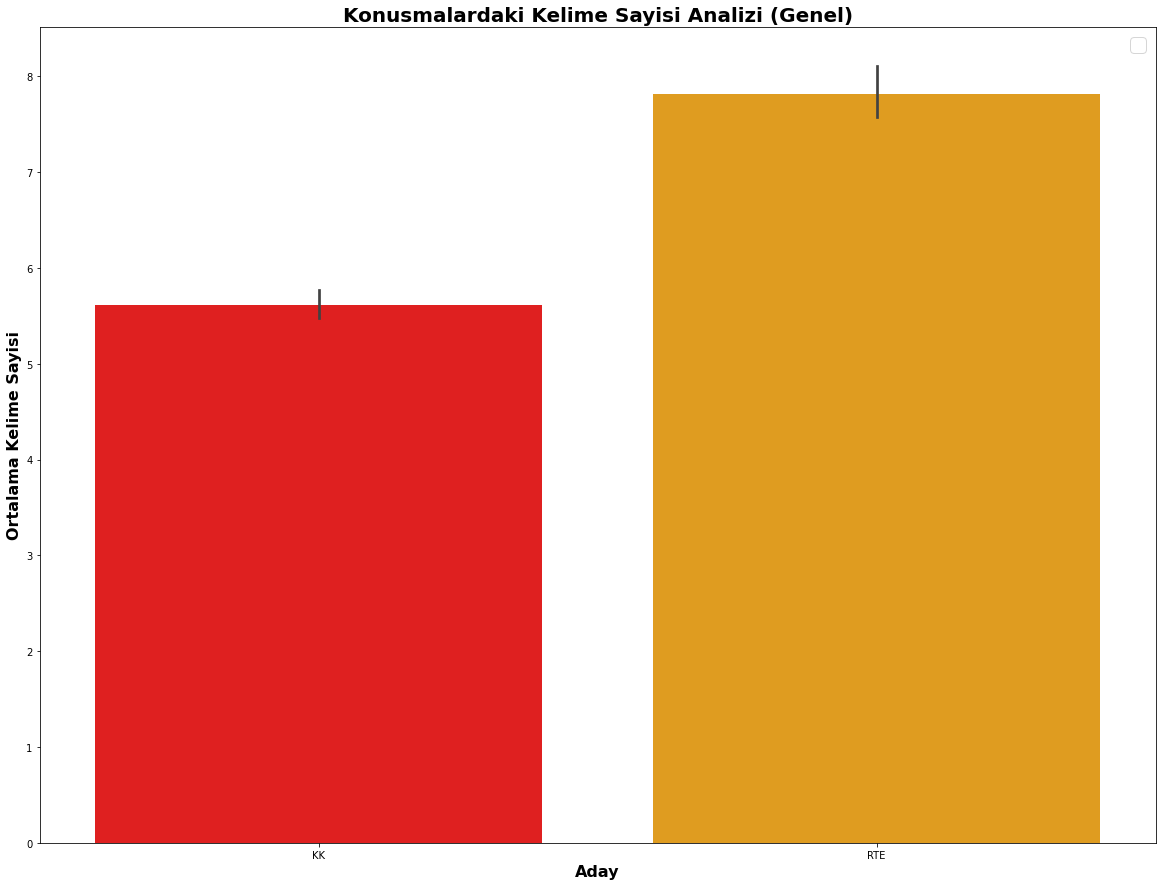

In [57]:
plt.figure(figsize=(20, 15)) 
sns.barplot(x='candidate', 
             y='word_count',
             palette=['red', 'orange'],
             data=candidate_records)

plt.title(f'Konusmalardaki Kelime Sayisi Analizi (Genel)', 
          fontsize = 20, 
          loc='center', 
          fontdict=dict(weight='bold'))

plt.xlabel('Aday', fontsize = 16, fontdict=dict(weight='bold'))
plt.ylabel('Ortalama Kelime Sayisi', fontsize = 16, fontdict=dict(weight='bold'))
plt.legend(loc="upper right", frameon=True, fontsize=20)
plt.show()

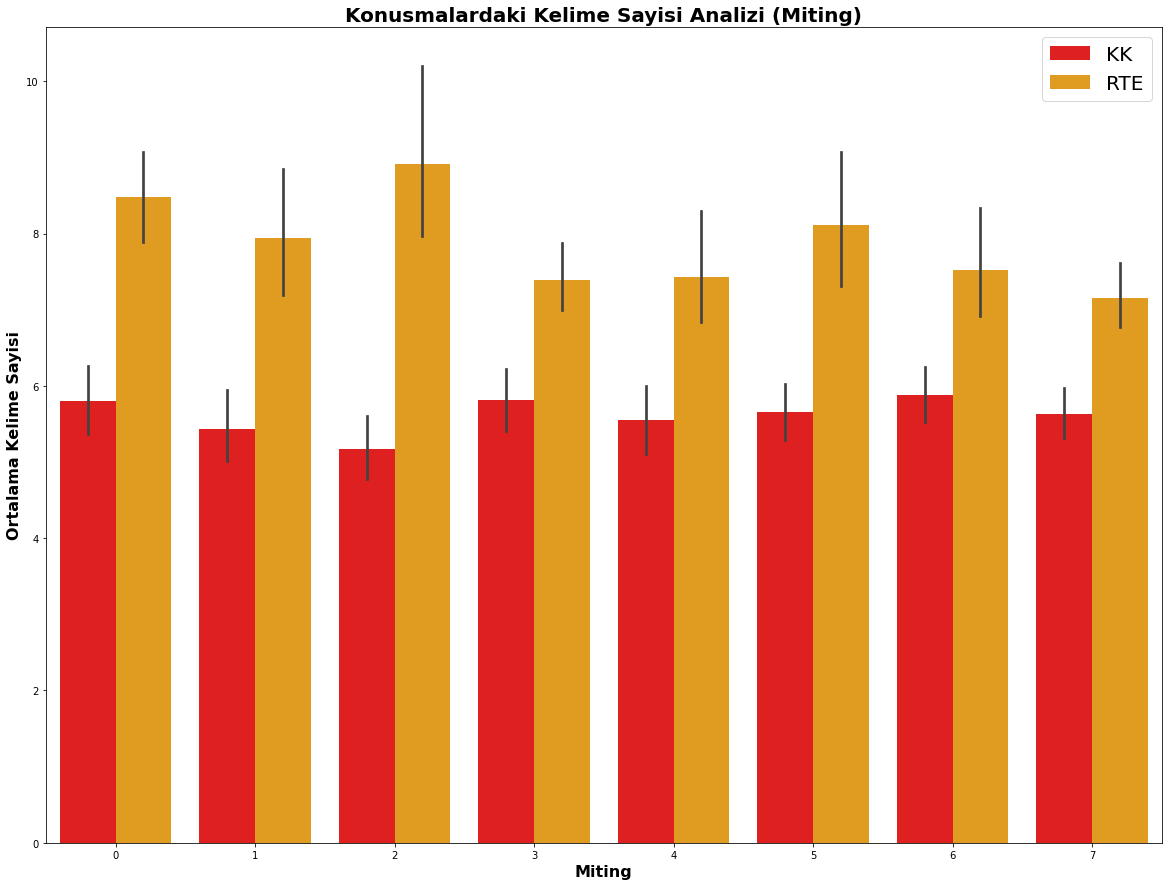

In [58]:
plt.figure(figsize=(20, 15)) 
sns.barplot(x='source', 
             y='word_count',
             palette=['red', 'orange'],
             hue='candidate',
             data=candidate_records)

plt.title(f'Konusmalardaki Kelime Sayisi Analizi (Miting)', 
          fontsize = 20, 
          loc='center', 
          fontdict=dict(weight='bold'))

plt.xlabel('Miting', fontsize = 16, fontdict=dict(weight='bold'))
plt.ylabel('Ortalama Kelime Sayisi', fontsize = 16, fontdict=dict(weight='bold'))
plt.legend(loc="upper right", frameon=True, fontsize=20)
plt.show()

notes:
- KK: genelde turkiye kullaniyor
- RTE: hep sehir ismi kullaniyor ve unigram'da hep en onemlilerde
- KK: secim tarihinden cok bahsetmiyor
- RTE: bigramlari inceledigimizde, 'on dort mayis' tarihi uzerinden hep bir vurgu var